In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr
from numpy.linalg import inv

def _inv(x):
    """
    Matrix inverse which also handles scalars properly
    :param x:
    :return:
    """
    try:
        return inv(x)
    except ValueError:
        return np.array([[1.0/x]])



In [2]:
%%capture
%run Covariance.ipynb
%run ODESolver.ipynb

# Unscented Transform

$$
\def\M#1{{[\mathbf{#1}]}}
\def\MM#1#2{{[\mathbf{#1}{#2}]}}
$$
Several parts of the Kalman filter require a matrix in one frame to be transformed into that of another frame. For example, the time update of the linear Kalman filter uses the state transition matrix to transform the state covariance matrix forward in time:

$$\MM{P}{^-_i}=\M{A}\MM{P}{^+_{i-1}}\M{A}^T+\M{Q}$$

Also, calculating the Kalman gain requires transforming the state covariance matrix to measurement space:

$$\M{\Gamma}=\M{H}\MM{P}{^-_{i}}\M{H}^T+\M{R}$$

In a problem with nonlinear physics, there is no such matrix $\M{A}$, and in a problem with nonlinear observations, there is no such matrix $\M{H}$. The extended Kalman filter calculates approximations to these matrices by using the Jacobian matrix of the dynamics and/or observation functions. This requires the Jacobian matrix to be available, either from explicitly derived formulas or numerical finite difference approximations.

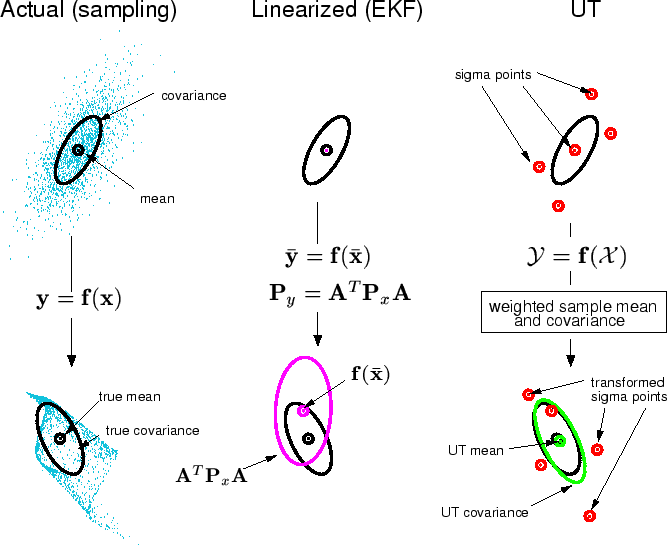
In this example, the top left shows the normally-distributed input with its mean and covariance, while the bottom-left shows that point cloud washed through a quite nonlinear transformation. Using methods shown before, it is easy to measure the covariance of the point cloud after the transformation. This covariance is still valid, even though the distribution is no longer Gaussian. This is the correct way to do the transformation, but is enormously expensive. Look at all the points you have to track! In order to actually implement this Monte Carlo method, you have to generate a large (ideally infinite, but who has time for that?) number of samples with the appropriate distribution around the estimated state, then propagate each sample through the nonlinear transformation. It ends up being an infinity-squared problem, where you want an infinite number of points, and want to walk each of them through a numerical integrator with an infinite number of steps.

In the middle column, we linearize the transformation about the mean to get $\M A$, then run the original covariance through it. The purple ellipse shows this transformation, and shows that it is not particularly close to the actual covariance.

In the right column, we do a hybrid. Instead of using a potentially infinite number of points and transforming all of them, we use a very-carefully selected *finite* number of points, on the order of a few for each element of the state vector. We run each of those through the nonlinear transformation, then use a weighted average and weighted sample covariance finder to get the mean and covariance estimates. The diagram indicates that this is much closer to the actual results. This is provable, *if* we carefully choose our samples (called sigma-points) and *if* we use the right weighting when calculating the mean and covariance. This is the unscented transform -- using a finite carefully selected set of sigma points to approximate the result we would get with an infinite set of Monte Carlo points.

Although we are looking at the estimate covariance here, we can do the same thing with the nonlinear transform from state space to measurement space to get the transformed measurement covariance.

Note that in neither case do we end up with an explicit $\M A$ or $\M H$. The filter form will have to be adapted to deal with this. In pseudocode the appropriate equations are replaced with:

$$\begin{eqnarray*}
(\vec{x}^-,\MM{P}{^-_i})&=&UT(f,\vec{x}_{i-1},\MM{P}{_{i-1}}) &+ &\M Q \\
\M \Gamma&=&UT(g,\MM{P}{^-_i})&+&\M R
\end{eqnarray*}$$

where $UT(h,\M M)$ is the unscented transform of $\M M$ using the nonlinear transformation function $h$. Specifically, $\vec{x}^-_i=f(\vec{x}_{i-1})$ is the state transformation function, and $\vec{y}=g(\vec{x})$ is the measurement function. Function $f$ is often calculated by numerical integration of $\dot{\vec{x}}=F(\vec{x})$, while $g$ is often calculated directly but with components involving trigonometry, square roots, or other nonlinear functions.

Performing the unscented transform then requires the following three steps:

1. Calcuate the sigma points and weights
2. Transform each sigma point
3. Reconstruct the mean and covariance from the transformed sigma points

Each of these steps will be discussed in turn.

## Constructing the sigma points
Given a mean value $\vec{x}$ in an $n$-dimensional space, and an $n \times n$ covariance matrix about that mean $\M{P}$, we do the following to construct the sigma points. Notice that this is a recipe with no justification, for that see the papers. The exact form of the following recipe is drawn from UKF1.pdf .

The points are constructed in two series:

$$\begin{eqnarray*}
\vec{x}_j&=&\vec{x}+\left(\sqrt{n\M{P}}\right)_j \\
W_j&=&\frac{1}{2n} \\
\vec{x}_{j+n}&=&\vec{x}-\left(\sqrt{n\M{P}}\right)_j \\
W_{j+n}&=&\frac{1}{2n}
\end{eqnarray*}$$

where $\left(\sqrt{\M{M}}\right)_j$ is row or column $j$ (0-based) of the matrix square root of $\M{M}$. We run this for each value of $j$ from 0 to $n-1$. Use a Cholesky decomposition to find this square root. If your decomposition algorithm produces $\M{A}=\sqrt{\M{M}}$ such that $\M{M}=\M{A}^T\M{A}$, then use ''rows'' of $\M{A}$. This is referred to as the ''upper'' triangular decomposition, because $\M{A}$ will be upper triangular. Otherwise if $\M{M}=\M{A}\M{A}^T$ then use ''columns'' of $\M{A}$. This is referred to as the ''lower'' triangular decomposition, for similar reasons. The numpy function `numpy.linalg.cholesky()` returns the lower form, so we pull columns out of it.

Other sets of sigma points can be constructed, some of which may match the uncertainty distribution in higher-order moments than just mean and covariance. The requirement is that the sum of the weights is 1

$$\sum_{j}W_j=1$$

Each individual weight may be positive or negative. For instance, if the original distribution is Gaussian, you can add a point at the mean, adjust the weights, and match the fourth order moment of the Gaussian distribution (Third order, skewness, is zero for a Gaussian). In this case we have:

$$\begin{eqnarray*}
\vec{x}_0&=&\vec{x} \\
W_0&=&1/3 \\
\vec{x}_{j+1}&=&\vec{x}+\left(\sqrt{\frac{n}{1-W_0}\M{P}}\right)_j \\
W_{j+1}&=&\frac{1-W_0}{2n} \\
\vec{x}_{j+n+1}&=&\vec{x}-\left(\sqrt{\frac{n}{1-W_0}\M{P}}\right)_j \\
W_{j+n+1}&=&\frac{1-W_0}{2n} \\
\end{eqnarray*}$$

In general, $W_0=1/3$ is recommended for the Gaussian distribution. Higher values tend to move the points further from the mean, while lower values move the points closer. $W_0=1$ is a particularly bad value. It weights the central point 100%, and forces the other values to divide by zero and weight that result 0%.


[[-100.          -97.         -100.         -103.         -100.        ]
 [-200.         -197.         -198.26794919 -203.         -201.73205081]]
[0.33333333 0.16666667 0.16666667 0.16666667 0.16666667]


<IPython.core.display.Javascript object>


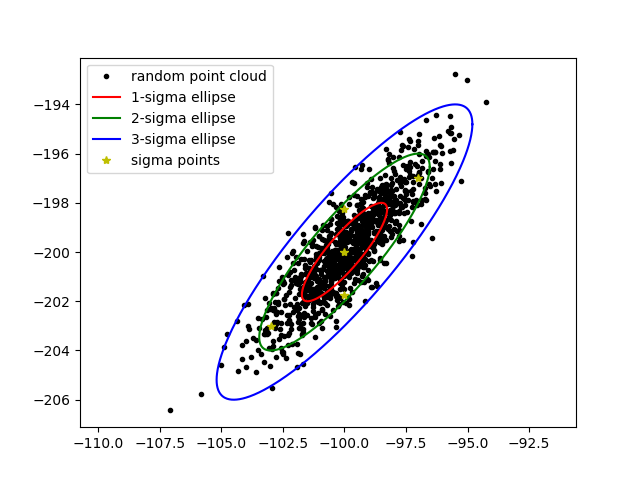

In [3]:
def sigma(x,P,W0=1/3):
    """
    Construct a set of sigma points and weights
    :param x: Initial vector
    :param P: Covariance of vector
    :return: A tuple:
       sigx - a numpy 2D array holding a bunch of column vectors, one for each sigma point
       W   - a numpy 1D array holding the weights -- W[j] is the weight for sigma[:,j]
    """
    n=x.size
    sig=np.zeros((n,2*n+1))
    W=np.zeros(2*n+1)+(1-W0)/(2*n)
    sig[:,0]=x.ravel()
    W[0]=W0
    snP=cholesky((n/(1-W0))*P)
    #print(snP)
    #print(snP@snP.T)
    #print(n/(1-W0))
    for j in range(n):
        sig[:,j  +1]=(x+snP[:,j].reshape(-1,1)).ravel()
        sig[:,j+n+1]=(x-snP[:,j].reshape(-1,1)).ravel()
    return (sig,W)

x0=np.array([[-100],[-200]])
P=np.array([[3,3],[3,4]])
(sig,W)=sigma(x0,P)
print(sig)
print(W)
nr.seed(3217)
x=pnoise(1000,P,x0)
e1=pell(1,P,x0)
e2=pell(2,P,x0)
e3=pell(3,P,x0)
plt.figure("Sigma point demo")
plt.plot(x [0,:],x [1,:],'k.',label='random point cloud')
plt.plot(e1[0,:],e1[1,:],'r-',label='1-sigma ellipse')
plt.plot(e2[0,:],e2[1,:],'g-',label='2-sigma ellipse')
plt.plot(e3[0,:],e3[1,:],'b-',label='3-sigma ellipse')
plt.plot(sig[0,:],sig[1,:],'y*',label='sigma points')
plt.axis('equal')
plt.legend()
plt.show()

## Transforming the Sigma Points
In general, you can use any old function which takes a vector and gives back a vector, either of the same number or different number of dimensions. However for the normal case used, the dynamics is determined by a first order vector ordinary differential equation. We end up with:

$$\begin{eqnarray*}
\dot{\vec{x}}&=&f(\vec{x},t)\\
\vec{x}(t)&=&\vec{x}(t_0)+\int_{t_0}^t f(\vec{x}(\tau),\tau) d\tau
\end{eqnarray*}$$

The latter is performed by any ODE solver, using the original point value as the initial condition. It's pretty common to use a quick, not-so-accurate solver, as the hope is that any errors caused by the ODE solver are drowned out by the errors naturally present in the covariance and measurement uncertainty. If we do it as a first-order one-step Euler solver, we end up with:

$$\vec{x}(t)=\vec{x}(t_0)+(t-t_0)f(\vec{x}(t_0),t_0)$$

The usual form for the observation function is just an explicit nonlinear function which calculates the measurement vector given the state vector. Usually no integration is needed.

We will say that the transformed value of each input point $\vec{x}_j$ is $\vec{x}_j'$, so we have for general nonlinear function $\operatorname h(\vec{x})$

$$\vec{x}_j'=\operatorname h(\vec{x}_j)$$

## Reconstructing the Distribution
Again, this is presented without justification, as a pure recipe. However, when you perform these operations on the untransformed sigma points, you *do* get back the original mean and covariance.

The transformed mean $\vec{x}'$ is then

$$\vec{x}'=\sum_j W_j \vec{x}'_j$$

For the preferred extra mean point above, the index $j$ runs from $0$ to $2n$ inclusive.

The transformed covariance is then

$$\MM{P}{'}=\sum_j W_j \left\{\vec{x}'_j-\vec{x}'\right\}\left\{\vec{x}'_j-\vec{x}'\right\}^T$$

Note that in the case of transforming from state space to measurement space, the resulting mean and covariance will have size $m$ and $m \times m$ where $m$ may not equal $n$. In fact the usual case for a Kalman filter is that $m \lt n$. Even so, the sums above run $j$ over each sigma point, the number of which is determined by the number of elements in state space, not measurement space.

[[-100.]
 [-200.]] [[-100]
 [-200]]
[[3. 3.]
 [3. 4.]]
[[-1.42108547e-14]
 [ 0.00000000e+00]]
True
[[ 4.4408921e-16  4.4408921e-16]
 [ 4.4408921e-16 -1.0658141e-14]]
False


<IPython.core.display.Javascript object>


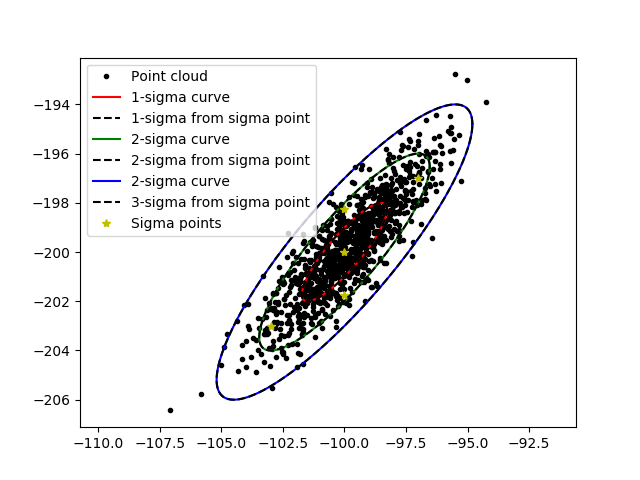

In [4]:
def sigmainv(sig,W):
    x=np.sum(sig*W.reshape(1,-1),axis=1).reshape(-1,1)
    #print(x)
    nn=sig.shape[1] #Number of sigma points
    P=np.zeros((x.size,x.size))
    #print(P.shape)
    for j in range(nn):
        #print("sig[j=%d]: "%j)
        #print(sig[:,j].reshape(-1,1))
        dx=(x-sig[:,j].reshape(-1,1))
        #print("dx=")
        #print(dx)
        Pterm=W[j]*(dx@dx.T)
        #print("Pterm=")
        #print(Pterm)
        P+=W[j]*(dx@dx.T)
        #print("P=")
        #print(P)
    return (x,P)

(xout,Pout)=sigmainv(sig,W)
print(xout,x0)
print(Pout)
print(xout-x0)
print(np.max(np.abs(xout-x0))<1)
print(Pout-P)
print(np.max(np.abs(Pout-P ))<1e-15)
e1out=pell(1,Pout,xout)
e2out=pell(2,Pout,xout)
e3out=pell(3,Pout,xout)
plt.figure("Sigma point reconstruct")
plt.plot(x [0,:],x [1,:],'k.',label='Point cloud')
plt.plot(e1[0,:],e1[1,:],'r-',label='1-sigma curve')
plt.plot(e1out[0,:],e1out[1,:],'k--',label='1-sigma from sigma point')
plt.plot(e2[0,:],e2[1,:],'g-',label='2-sigma curve')
plt.plot(e2out[0,:],e2out[1,:],'k--',label='2-sigma from sigma point')
plt.plot(e3[0,:],e3[1,:],'b-',label='2-sigma curve')
plt.plot(e3out[0,:],e3out[1,:],'k--',label='3-sigma from sigma point')
plt.plot(sig[0,:],sig[1,:],'y*',label='Sigma points')
plt.axis('equal')
plt.legend()
plt.show()

# Example transform
We will take a look at a test mass making a close pass by a central mass. The error ellipsoid is large enough that during the passage by the center, samples in different parts of the error ellipsoid will make passes at large differences in distance and therefore will be scattered quite a lot. This is intended to activate the nonlinearity inherent in the problem.

Our physics function is the same for all propagators. We will do the physics function symbolically so that we can do automatic symbolic derivatives to feed the EKF what it needs. The Monte Carlo and Unscented propagators won't need the Jacobian, but can use the vector derivative just as well as the Extended propagator can.

In [5]:
%%capture
%run NonlinearKalman.ipynb
    

In [6]:
#Symbolic form of physics equations
rx,ry,vx,vy=sympy.symbols('r_x r_y v_x v_y')
#It's OK to introduce intermediate symbols, since they are still defined in terms
#of the symbols we will be using in the state vector
r=sympy.sqrt(rx**2+ry**2) 
Frx=vx
Fry=vy
Fvx=-rx/r**3
Fvy=-ry/r**3
(Fnl,Phinl)=fjac([rx,ry,vx,vy],[],[Frx,Fry,Fvx,Fvy])

State vector: 


Matrix([
[r_x],
[r_y],
[v_x],
[v_y]])

Parameters: 


[]

Physics Function: 


Matrix([
[                          v_x],
[                          v_y],
[-r_x/(r_x**2 + r_y**2)**(3/2)],
[-r_y/(r_x**2 + r_y**2)**(3/2)]])

Physics Matrix: 


Matrix([
[                                           0,                                             0, 1, 0],
[                                           0,                                             0, 0, 1],
[(2*r_x**2 - r_y**2)/(r_x**2 + r_y**2)**(5/2),            3*r_x*r_y/(r_x**2 + r_y**2)**(5/2), 0, 0],
[          3*r_x*r_y/(r_x**2 + r_y**2)**(5/2), (-r_x**2 + 2*r_y**2)/(r_x**2 + r_y**2)**(5/2), 0, 0]])

Help on function _lambdifygenerated:

_lambdifygenerated(r_x, r_y, v_x, v_y)
    Created with lambdify. Signature:
    
    func(r_x, r_y, v_x, v_y)
    
    Expression:
    
    Matrix([[v_x], [v_y], [-r_x/(r_x**2 + r_y**2)**(3/2)], [-r_y/(r_x**2 +...
    
    Source code:
    
    def _lambdifygenerated(r_x, r_y, v_x, v_y):
        return (array([[v_x], [v_y], [-r_x/(r_x**2 + r_y**2)**(3/2)], [-r_y/(r_x**2 + r_y**2)**(3/2)]]))
    
    
    Imported modules:

Help on function _lambdifygenerated:

_lambdifygenerated(r_x, r_y, v_x, v_y)
    Created with lambdify. Signature:
    
    func(r_x, r_y, v_x, v_y)
    
    Expression:
    
    Matrix([[0, 0, 1, 0], [0, 0, 0, 1], [(2*r_x**2 - r_y**2)/(r_x**2 +...
    
    Source code:
    
    def _lambdifygenerated(r_x, r_y, v_x, v_y):
        return (array([[0, 0, 1, 0], [0, 0, 0, 1], [(2*r_x**2 - r_y**2)/(r_x**2 + r_y**2)**(5/2), 3*r_x*r_y/(r_x**2 + r_y**2)**(5/2), 0, 0], [3*r_x*r_y/(r_x**2 + r_y**2)**(5/2), (-r_x**2 + 2*r_y**2)/(r_x**2 + r

The initial condition is also the same between propagators

In [7]:
t0=0
t1=20
dt=0.1
ts=np.arange(t0,t1,dt) #Time series
n_t=ts.size
x0=np.array([[8],[2],[-0.5],[0]])
P0=np.diag([0.01,0.01,1e-5,1e-5])
nstep=1

Since we know that this is gravity with $\mu=1$, we can use the solution to the Kepler problem to get our exact answer:

In [8]:
%%capture
%run UniversalVariables.ipynb

In [9]:
elorb(x0)

elorb(p=1.0000000000000149, a=-133.9696900098825, e=1.003725248742736, i=0.0, an=0.0, ap=0.0, ta=3.6459797427822367, tp=12.011268169076583, rp=0.4990704192740388, MM=-0.007746027502653352, n=0.0006448967247768026, t=nan)

We will be comparing three propagators:

* The Monte Carlo propagator. This one generates a large cloud of points at random, with the desired initial mean and covariance. The larger the cloud, the better. With a large enough point cloud, we expect this one to be the best representation of "truth", but also the most computationally intensive.

/mnt/big/home/chrisj/workspace/python/jupyter/venv/lib/python3.6/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in log
/mnt/big/home/chrisj/workspace/python/jupyter/venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/mnt/big/home/chrisj/workspace/python/jupyter/venv/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract
/mnt/big/home/chrisj/workspace/python/jupyter/venv/lib/python3.6/site-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in greater
/mnt/big/home/chrisj/workspace/python/jupyter/venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/mnt/big/home/chrisj/workspace/python/jupyter/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/mnt/bi

(4, 200)


<IPython.core.display.Javascript object>


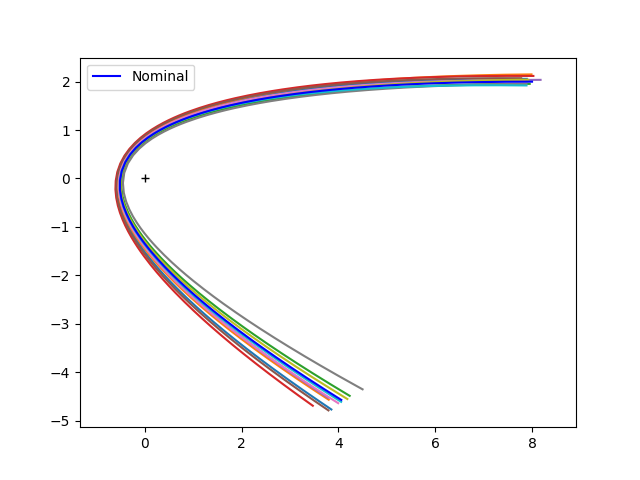

(200, 4, 1000)


<IPython.core.display.Javascript object>


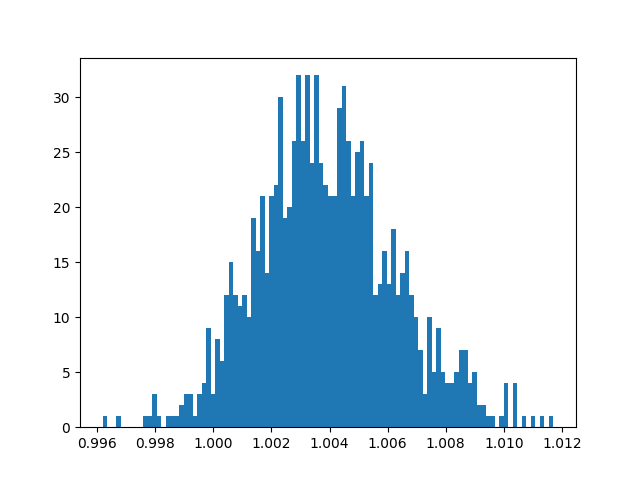

In [10]:
n_cloud=1000 #Number of elements in the point cloud
nr.seed(3217)
xm = pnoise(n_cloud, P0, x0)
el=elorb(xm)
#Now we can calculate the whole trajectory of a whole point cloud at once
xt=kepler(x0,None,np.arange(0,20,0.1))
xtm=kepler(xm,None,np.arange(0,20,0.1).reshape(-1,1,1))
print(xt.shape)
plt.figure("Nominal trajectory")
plt.plot(0,0,'k+')
print(xtm.shape)
#Plot the first 10 trajectories
for i in range(np.min((10,xtm.shape[2]))):
    plt.plot(xtm[:,0,i],xtm[:,1,i])
plt.plot(xt[0,:],xt[1,:],'b',label='Nominal')
plt.legend()
plt.axis('equal')
plt.show()
plt.figure("Eccentricity histogram")
plt.hist(el.e,100)
plt.show()

Note that the eccentricity of the point cloud includes some values less than 1, indicating that some orbits in the cloud will be elliptical.

* The Extended Kalman Filter propagator. This one propagates the mean (or current best estimate) and uses the Jacobian of the physics function to propagate the covariance. It is expected to be the least accurate propagator of the covariance, but the performance benchmark against which to compare the Unscented propagator. 

In [11]:
xe=x0*1
Pe=P0*1

* The Unscented transform propagator. This uses a finite number of carefully chosen points, as opposed to the ideally infinite number that the Monte Carlo propagator uses. We expect it to have a propagated covariance closer to the Monte Carlo "Truth" value than the EKF propagator, and will compare its computational effort of propagating many sigma points to that of calculating and using the Jacobian matrix for the EKF.

In [12]:
(xu, W) = sigma(x0, P0)

Now we run all of the propagators in lockstep, using the same physics function, same initial condition, same time steps, etc. 

<IPython.core.display.Javascript object>


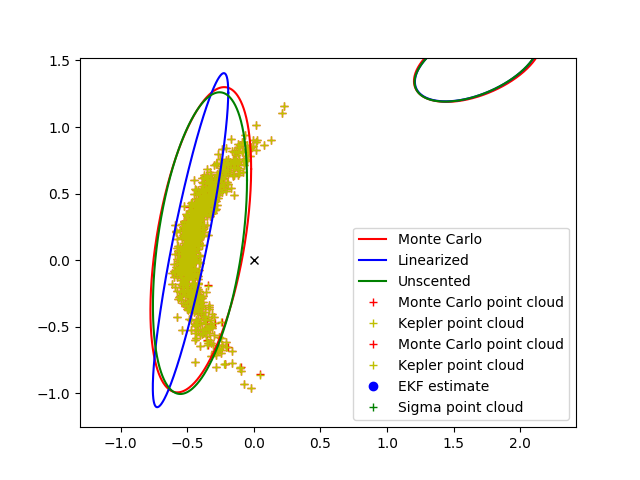

In [13]:
plt.figure("EKF, MCKF, and UKF")
plt.plot([0], [0], 'kx')
dt=ts[1]-ts[0]
for i, t in enumerate(ts):
    #Do all of the plotting
    if i % 20 == 0 or i+1==len(ts):
        if i+1==len(ts) or i==120:
            plt.plot(xm[0, :], xm[1, :], 'r+',label="Monte Carlo point cloud")
            plt.plot(xtm[i,0,:],xtm[i,1,:],'y+',label="Kepler point cloud")
        (xmbar, Pm) = pcalc(xm)
        (cm, sm) = pell(3, Pm[0:2,0:2], xmbar[0:2])
        plt.plot(cm, sm, 'r-',label='Monte Carlo' if i==0 else None)

        if i+1==len(ts):
            plt.plot(xe[0, :], xe[1, :], 'bo',label="EKF estimate")
        (ce, se) = pell(3, Pe[0:2,0:2], xe[0:2])
        plt.plot(ce, se, 'b-',label='Linearized' if i==0 else None)

        if i+1==len(ts):
            plt.plot(xu[0, :], xu[1, :], 'g+',label="Sigma point cloud")
        (xubar, Pu) = sigmainv(xu, W)
        (cu, su) = pell(3, Pu[0:2,0:2], xubar[0:2])
        plt.plot(cu, su, 'g-',label='Unscented' if i==0 else None)
    #Actually step the integrators
    xm = rk4(Fnl, dt, xm, [], nstep=nstep)
    xu = rk4(Fnl, dt, xu, [], nstep=nstep)
    (xe, Pe) = ekf_timeup(xe, Pe, dt, Fnl, [], Phinl, nstep=nstep)
plt.axis('equal')
plt.legend()
plt.show()

# Measurement Update
We have seen on the Extended Kalman Filter page how we end up with a linearized measurement matrix $\M H$, calculated as the Jacobian of the measurement equations with the state vector components. The problem with the Unscented filter then is how do we transform to and from measurement space without the linearized matrix?

In what follows, vector $\hat{z}$ is the predicted measurement, and is not necessarily a unit-vector. Vector $\vec{z}$ is the actual measurement at the given time $t$. Vector $\vec{y}=\vec{z}-\hat{z}$ is the residual.

 1. Calculate the predicted measurement for each sigma point $$\hat{z}_j=\operatorname h(\vec{x}^-_j,t)$$
 2. Calculate the mean and covariance of the predicted measurement $$\begin{align}\hat{z}=&\sum_{j=0}^{2n}W_j \hat{z}_j \\
\M{\Gamma}=&\M{R}+\sum_{j=0}^{2n}W_j \left\{\hat{z}-\hat{z}_j\right\}\left\{\hat{z}-\hat{z}_j\right\}^T\end{align}$$ The second term (the big summation term) has the same purpose as the corresponding term in the linear Kalman equation: $$\M \Gamma=\M R+\M H \MM{P}{^-_i}\M H^T$$ In that equation, the indicated term is the translation of the state estimate covariance into measurement space. Here we calculate this covariance directly from the transformed sigma points.
 3. Calculate the measurement residual $$\vec{y}=\vec{z}-\hat{z}$$
 4. Calculate the cross-covariance between the state and the residual $$\M{S}=\sum_{j=0}^{2n}W_j \left\{\vec{x}^--\vec{x}^-_j\right\}\left\{\hat{z}-\hat{z}_j\right\}^T$$ The corresponding linear Kalman equation is: $$\M S=\MM{P}{^-_i}\M H^T$$ We still haven't explained why this cross-covariance is a term of the Kalman gain matrix, but at least it is a little more clear what it is -- it's the cross-covariance between the state sigma points and the measurement sigma points.
 5. Calculate the Kalman gain, exactly like the linear filter: $$\M{K}=\M{S}\M{\Gamma}^{-1}$$
 6. Update the estimate, exactly like the linear filter: $$\vec{x}^+=\vec{x}^-+\M{K}\vec{y}$$
 7. Update the estimate covariance. We don't have $\M H$, so we can't do this exactly like the linear filter: $$\M{P}{^+}=\MM{P}{^-}-\M{K}\M{\Gamma}\M{K}^T$$ 
 

When we compare this last formula with the linear filter, we see this: $$\MM{P}{^+}=(\M{1}-\M{K}\M{H})\MM{P}{^-}$$ 
 
It's obvious why we can't use the linear form, since we don't have $\M H$. However, can we prove that these two lines are equivalent, and that we can calculate this with what we have?

$$\begin{eqnarray*}
\MM{P}{^+}&=&\MM{P}{^-}-\M{K}\M{\Gamma}\M{K}^T & \mbox{Unscented form} \\
  &=&\MM{P}{^-}-\M{S}\M{\Gamma}^{-1}\M{\Gamma}\M{K}^T & \mbox{Sub in definition of }\M{K}=\M{S}\M{\Gamma}^{-1}\mbox{ (same in both filters) in first spot} \\
  &=&\MM{P}{^-}-\M{S}\M{K}^T & \mbox{Cancel out multiplication of matrix with its own inverse} \\
  &=&\MM{P}{^-}-\MM{P}{^-}\M{H}^T\M{K}^T & \mbox{Sub in definition of }\M{S}=\MM{P}{^-}\M H^T\mbox{ from linear filter} \\
  &=&\MM{P}{^-}(\M{1}-\M{H}^T\M{K}^T) & \mbox{Factor out }\MM{P}{^-} \\
\MM{P}{^+}^T&=&(\M{1}-\M{H}^T\M{K}^T)^T\M{P^-}^T & \mbox{Since }\M{P}\mbox{ is symmetric, }\M{P}=\M{P}^T\mbox{ and we can do this. On right side, }(\M{A}\M{B})^T=\M{B}^T\M{A}^T \\
 &=&(\M{1}^T-(\M{H}^T\M{K}^T)^T)\M{P^-}^T & \mbox{On right side, }(\M{A}+\M{B})^T=\M{A}^T+\M{B}^T \\
\MM{P}{^+}&=&(\M{1}-(\M{H}^T\M{K}^T)^T)\M{P^-} & \mbox{Identity matrix is symmetric, }\M{1}=\M{1}^T\mbox{, as are }\M{P}\mbox{ and }\M{P^-} \\
     &=&(\M{1}-\M{K}\M{H})\M{P^-} & \M{A}^T\M{B}^T=\M{B}\M{A}\mbox{ which gets us to the linear form}
\end{eqnarray*}$$

So yes, we can reconcile that last line. Both calculate the same thing. The UKF form can even be used in the KF or EKF if it is convenient.

# Augmented state
If we are considering nonlinear transformations, we might as well consider nonlinear process noise as well. Instead of in the form:

$$\begin{eqnarray*}
\vec{x}^-&=&f(\vec{x}_{i-1})+\vec{v} \\
\MM{P}{^-}&=&UT(f,\MM{P}{_{i-1}})+\M Q
\end{eqnarray*}$$

we *augment* the state vector with a process noise vector. 

$$\vec{x}_a=\begin{bmatrix}\vec{x} \\ - \\ \vec{v}\end{bmatrix}$$

We will need an augmented physics function $f_a$ as well, which accepts an augmented vector and uses the noise vector components to implement noise (not in general adding the noise). The return vector will be un-augmented, and therefore the covariance is compatible with the un-augmented state vector.

So if we have a state vector $\vec{x}$ with $n$ components, and noise vector $\vec{v}$ with $\ell$ components, we will end up with an augmented state vector $\vec{x}_a$ with $n+\ell$ components. We then generate sigma points with an augmented covariance -- often it is a block-diagonal covariance like this:

$$\MM{P}{_a}=\begin{bmatrix}\M P & \MM{0}{_{n \times \ell}} \\
                               \MM{0}{_{\ell \times n}} & \M{Q}\end{bmatrix}$$
                               
The off-diagonal blocks are the cross-covariance between the state and the process noise. It's fair to treat them as zero, meaning that there is no correlation between the state and the noise.

When we generate sigma points with the augmented covariance, we will end up with $2(n+\ell)+1$ sigma points, each of which is $n+\ell$ elements long. After running all of them through the augmented nonlinear transformation, we will end up with $2(n+\ell)+1$ points still, but now each vector is only $n$ elements long. When we calculate the updated covariance $\M P$, it will only be $n \times n$.

$$\begin{eqnarray*}
\vec{x}^-&=&f(x_{a,i-1}) \\
\MM{P}{^-}&=&UT(f_a,\MM{P}{_{a,i-1}})
\end{eqnarray*}$$

This particular problem is quite sensitive to the integrator and number of time substeps used. 

# Example 2 - Atmospheric Entry
Let's try another one -- the dreaded Atmospheric Entry problem that the original authors used as their test case.

The following problem is simple to describe but apparently is a difficult problem for the extended Kalman filter to handle. 

A spherical reentry vehicle (no lift) is entering the atmosphere of Earth at a relatively steep angle and orbital speed. The rotation of the Earth is neglected, and all motion happens in a plane. 

The atmosphere model is a simple exponential, and the ballistic coefficient not a function of mach number. The ballistic coefficient is subject to a random walk, as are both components of the velocity, but not either component of the position.

A radar station is tracking the vehicle, producing range and azimuth measurements at a high rate. 
## Equations of Motion
The state vector $\vec{x}$ to be estimated is the 2D position ($x_1$ and $x_2$), 2D velocity ($x_3$ and $x_4$), and ballistic coefficient of the vehicle ($x_5$). As stated above, the motion is subject to a random walk $\vec{v}$ on three components, the 2D velocity ($v_1$ and $v_2$) and ballistic coefficient ($v_3$). The equations of motion of the vehicle are then as follows:

$$\begin{eqnarray*}
\dot{x}_1&=&x_3\\
\dot{x}_2&=&x_4\\
\dot{x}_3&=&Dx_3+Gx_1+v_1\\
\dot{x}_4&=&Dx_4+Gx_2+v_2\\
\dot{x}_5&=&v_3
\end{eqnarray*}$$

where $D$ is the drag-related force term, $G$ is the gravity-related force term, $R$ is the distance from the reentry vehicle to the center of the Earth, $R_0$ is the radius of the Earth, $Gm_0$ is the gravitational parameter of the Earth, and $H_0$ is the density scale height of the atmosphere. These terms are evaluated as follows:

{{sidebar|Both UKF0.pfd and UKF1.pdf had an error here, $\beta_0$ should be positive}}
$$\begin{align}
R_0=&6374\mbox{ km}\\
Gm_0=&3.9860\times 10^5 \mbox{ km}^3/\mbox{s}^2\\
H_0=&13.406 \mbox{ km}\\
\beta_0=&0.59783 \\
R=&\sqrt{x_1^2+x_2^2}\\
V=&\sqrt{x_3^2+x_4^2}\\
\beta=&\beta_0 e^{x_5}\\
G=&-\frac{Gm_0}{R^3}\\
D=&-\beta V e^{\left\{\frac{R_0-R}{H_0}\right\}}\\
\end{align}$$

The $G$ term does in fact produce the centrally-directed inverse-square term we've grown to know and love, and the $D$ term does produce a drag opposite in direction to the velocity with magnitude proportional to the square of the speed.

The ballistic coefficient $\beta$ is calculated in this roundabout manner rather than directly estimated because the filter is not smart enough to constrain the ballistic coefficient to be positive. With this indirect method, any real number state vector component produces a valid positive ballistic coefficient.

In [ ]:
x_1=sympy.symbols("x_1")
x_2=sympy.symbols("x_2")
x_3=sympy.symbols("x_3")
x_4=sympy.symbols("x_4")
x_5=sympy.symbols("x_5")
#v_1=sympy.symbols("v_1")
#v_2=sympy.symbols("v_2")
#v_3=sympy.symbols("v_3")
R_0=6374
Gm_0=3.9860e5
H_0=13.406
beta_0=0.59783
R=sympy.sqrt(x_1**2+x_2**2)
V=sympy.sqrt(x_3**2+x_4**2)
beta=beta_0*sympy.exp(x_5)
G=-Gm_0/R**3
D=-beta*V*sympy.exp((R_0-R)/H_0)
Fx_1=x_3
Fx_2=x_4
Fx_3=D*x_3+G*x_1#+v_1
Fx_4=D*x_4+G*x_2#+v_2
Fx_5=0#v_3
display(sympy.simplify(Fx_3))
display(sympy.simplify(Fx_4))
(Fre,Phire)=fjac([x_1,x_2,x_3,x_4,x_5],[Fx_1,Fx_2,Fx_3,Fx_4,Fx_5])


## Measurement equations
The vehicle is tracked by a radar at $(x_r,y_r)$ which produces range and azimuth measurements. The measurements are determined from the state vector as follows:

$$\begin{align}
r_r=&\sqrt{(x_1-x_r)^2+(x_2-y_r)^2}+w_1\\
\theta=&\tan^{-1}\left(\frac{x_2-y_r}{x_1-x_r}\right)+w_2
\end{align}$$

{{sidebar|UKF0.pdf calls out this matrix only in the text and is inconsistent with the units. The units of variance must be $\mbox{m}^2$ and $\mbox{mrad}^2$ but are specified as $\mbox{m}$ and $\mbox{mrad}$. To correct this, either change the units and interpret the numbers as variances, or interpret the numbers as standard deviations and square them for the matrix. The matrix to the right does the former.}}
The measurements have a covariance as follows:

$$\M{R}=\begin{bmatrix}0.001 & 0 \\
0 & 0.017\end{bmatrix}$$

This means that the noise components are uncorrelated.


In [ ]:
x_r=R_0
y_r=0
w_1=sympy.symbols('w_1')
w_2=sympy.symbols('w_2')
r_r=sympy.sqrt((x_1-x_r)**2+(x_2-y_r)**2)+w_1
theta=sympy.atan((x_2-y_r)/(x_1-x_r))+w_2
display(r_r)
display(theta)

The problem initial conditions are:

In [ ]:
t0=0
t1=20
dt=0.1
ts=np.arange(t0,t1,dt) #Time series
n_t=ts.size
x0=np.array([[6500.4],[349.14],[-1.8093],[-6.7967],[0.6932]])
P0=np.diag([1e-6,1e-6,1e-6,1e-6,1e-12])
nstep=2

In [ ]:
#Monte Carlo initial condition
n_cloud=1000 #Number of elements in the point cloud
nr.seed(3217)
xm = pnoise(n_cloud, P0, x0)
#EKF initial condition
xe = x0.copy()
Pe = P0.copy()
#Unscented initial condition
(xu, W) = sigma(x0, P0)

plt.figure("Entry problem")
plt.plot([0], [0], 'kx')

dt=ts[1]-ts[0]
for i, t in enumerate(ts):
    if i % 20 == 0 or i+1==len(ts):
        if i+1==len(ts):
            plt.plot(xm[0, :], xm[1, :], 'r+',label="Monte Carlo point cloud")
        (xmbar, Pm) = pcalc(xm)
        (cm, sm) = pell(3, Pm[0:2,0:2], xmbar[0:2])
        plt.plot(cm, sm, 'r-',label='Monte Carlo' if i==0 else None)

        if i+1==len(ts):
            plt.plot(xe[0, :], xe[1, :], 'bo',label="EKF estimate")
        (ce, se) = pell(3, Pe[0:2,0:2], xe[0:2])
        plt.plot(ce, se, 'b-',label='Linearized' if i==0 else None)

        if i+1==len(ts):
            plt.plot(xu[0, :], xu[1, :], 'g+',label="Sigma point cloud")
        (xubar, Pu) = sigmainv(xu, W)
        (cu, su) = pell(3, Pu[0:2,0:2], xubar[0:2])
        plt.plot(cu, su, 'g-',label='Unscented' if i==0 else None)
    xm = euler(Fre, dt, xm, nstep=nstep)
    xu = euler(Fre, dt, xu, nstep=nstep)
    (xe, Pe) = ekf_step(xe, Pe, dt, Fre, Phire, nstep=nstep)
plt.axis('equal')
plt.legend()
plt.show()